In [1]:
import sys
import importlib
import pickle

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import visualisation
from models import torch_CVAE

pd.options.display.width = 1000

In [2]:
with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
    data, metadata = pickle.load(f)

In [3]:
dat = data
print(dat.shape)
feature_num = dat.shape[1]
dat = dat.reshape(-1,1,feature_num)
print(dat.shape)
label = metadata["PAM50_labels"]
feature_num = metadata["n_features"]

(1231, 10277)
(1231, 1, 10277)


In [4]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [5]:
batch_size = 32 # was 32 originally

train_data, test_data = train_test_split(dat, test_size = 0.1, random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = batch_size, shuffle=True)

train data: 1107
test data: 124


In [6]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For m1 Mac
DEVICE = torch.device("mps")

In [81]:
importlib.reload(torch_CVAE)

latent_dim = 64
model = torch_CVAE.Autoencoder(
    shape = feature_num,
    dropout = 0.2,
    latent_dim = latent_dim,
    is_variational = False,
    use_convolution= True
    ).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)

print(DEVICE)

mps


In [86]:
train_res_recon_error = []
perplexities = []
frames = []

def callbacks(epoch):
    if (epoch + 1) % 10 == 0:
        en_lat = []
        en_reconstruction = []

        model.eval()

        data_set = Mydatasets(data1 = dat)
        data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 
        

        for i in range(len(dat)):
            en_data = data_set.dataset[i][0]

            if model.is_variational:
                latent_1, _ = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
                data_recon, _, _ = model(en_data.view(1, 1, feature_num).float().to(DEVICE))


            else:
                latent_1 = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
                data_recon = model(en_data.view(1, 1, feature_num).float().to(DEVICE))

            

            en_lat.append(latent_1.cpu().detach().numpy())
            en_reconstruction.append(data_recon.cpu().detach().numpy())

        encode_out = np.array(en_lat).reshape(len(dat), -1)
        reconstruction_out = np.array(en_reconstruction).reshape(len(dat), -1)


        
        # PCA of the latent space
        pca = PCA(n_components=2)
        pca.fit(encode_out)
        pca_result = pca.transform(encode_out)


        index_column = np.full((pca_result.shape[0], 1), len(frames), dtype=int)

        pca_result_with_index = np.hstack((index_column, pca_result))

        frames.append(pca_result_with_index)

        if (epoch + 1) % 100 == 0:

            # stacking a single observation as well as its reconstruction in order to evaluate the results
            stack = np.vstack([dat[0].reshape(1, -1), reconstruction_out[0].reshape(1, -1)])

            # prepping a 1x4 plot to monitor the model through training
            fig, axs = plt.subplots(1, 4, figsize=(12, 3))


            # Plot the line plot in the second subplot
            axs[0].plot(train_res_recon_error, label='Training Loss')
            axs[0].set_title('Training Loss Plot')
            #axs[0].set_xticks([])

            sns.heatmap(stack, ax=axs[1], cbar=False)
            axs[1].set_title('Stacked heatmap of two samples')
            axs[1].set_xticks([])
            axs[1].set_yticks([])


            sns.heatmap(encode_out, ax = axs[2], cbar=False)
            axs[2].set_title('Heatmap of hole quantized dataset')
            axs[2].set_xticks([])
            axs[2].set_yticks([])


            sns.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], c=label, ax=axs[3])
            axs[3].set_title('PCA')
            #axs[3].set_xticks([])
            axs[3].set_yticks([])

            plt.subplots_adjust(wspace=0)  
            plt.tight_layout()
            plt.show()
        model.train()



0.0001


 10%|▉         | 99/1000 [15:23<1:55:32,  7.69s/it]

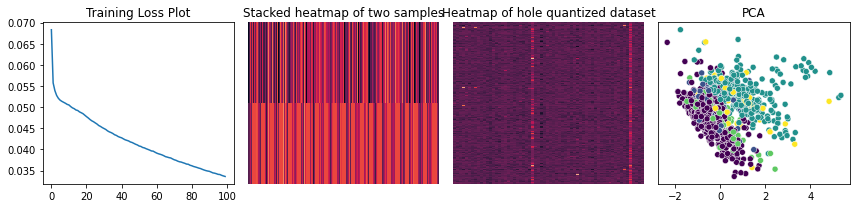

 20%|█▉        | 199/1000 [31:31<1:50:44,  8.29s/it]

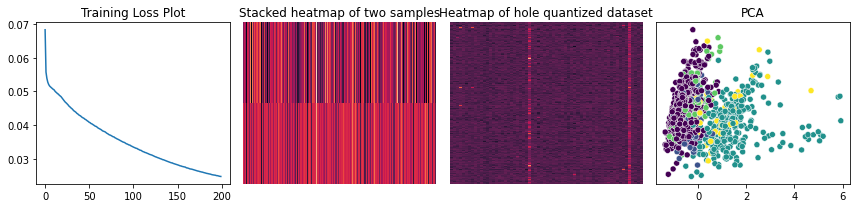

 30%|██▉       | 299/1000 [47:22<1:30:34,  7.75s/it]

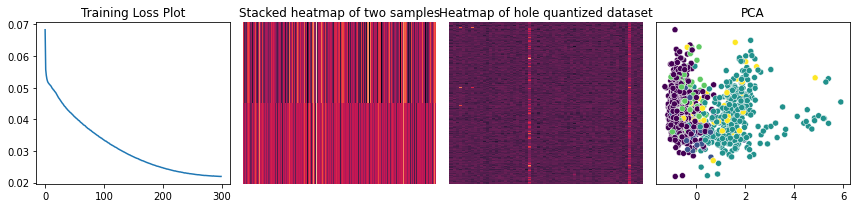

 40%|███▉      | 399/1000 [1:02:25<1:18:44,  7.86s/it]

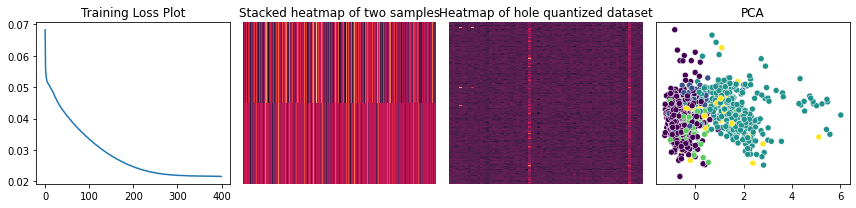

 50%|████▉     | 499/1000 [1:18:39<1:08:47,  8.24s/it]

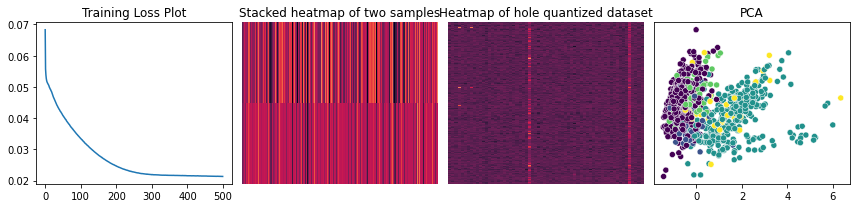

 60%|█████▉    | 599/1000 [1:35:06<55:06,  8.25s/it]  

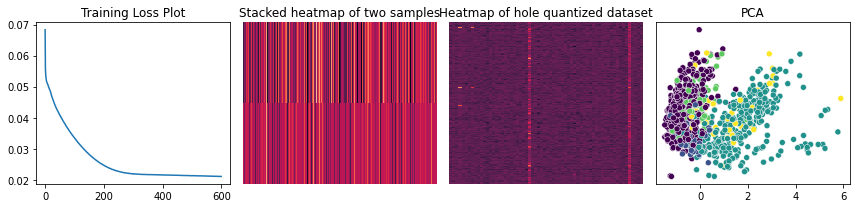

 70%|██████▉   | 699/1000 [1:51:41<41:30,  8.28s/it]  

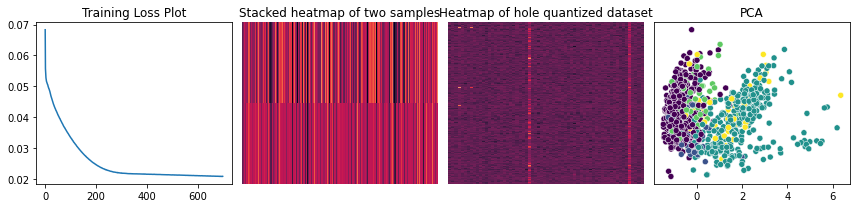

 80%|███████▉  | 799/1000 [2:08:17<26:03,  7.78s/it]  

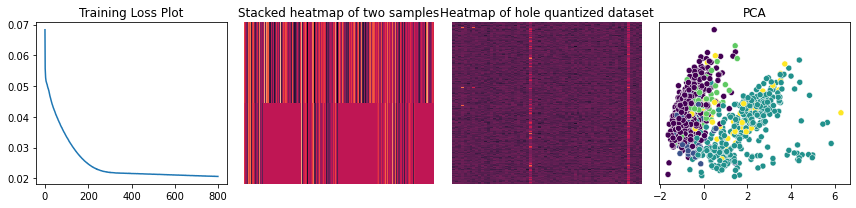

 90%|████████▉ | 899/1000 [2:24:06<13:58,  8.30s/it]

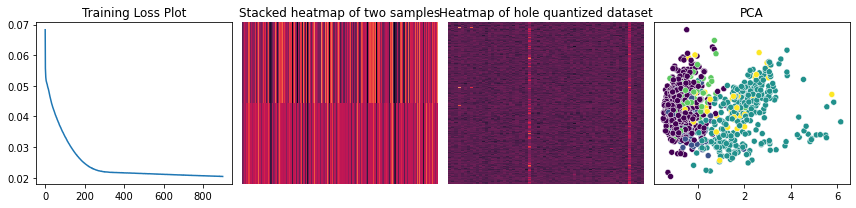

100%|█████████▉| 999/1000 [2:39:51<00:07,  7.73s/it]

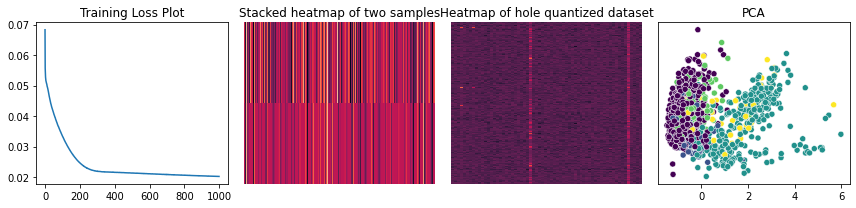

100%|██████████| 1000/1000 [2:40:14<00:00,  9.61s/it]

0.0001


In [87]:
EPOCH = 1000

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 0.000001)
print(optimizer.param_groups[0]['lr'])

model.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    
    # Training loop
    for _, inputs in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        # Compute the VAE loss or standard loss
        if model.is_variational:
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + (1 * kld)
        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    callbacks(epoch)

    


print(optimizer.param_groups[0]['lr'])


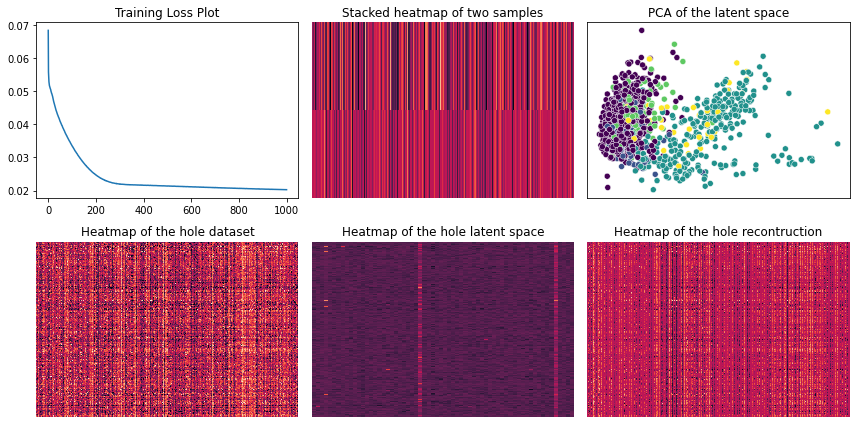

In [88]:
en_lat = []
en_reconstruction = []

model.eval()

data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]

    if model.is_variational:
        latent_1, _ = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
        data_recon, _, _ = model(en_data.view(1, 1, feature_num).float().to(DEVICE))


    else:
        latent_1 = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
        data_recon = model(en_data.view(1, 1, feature_num).float().to(DEVICE))

    

    en_lat.append(latent_1.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat).reshape(len(dat), -1)
reconstruction_out = np.array(en_reconstruction).reshape(len(dat), -1)



# PCA of the latent space
pca = PCA(n_components=2)
pca.fit(encode_out)
pca_result = pca.transform(encode_out)

# stacking a single observation as well as its reconstruction in order to evaluate the results
stack = np.vstack([dat[0].reshape(1, -1), reconstruction_out[0].reshape(1, -1)])

# prepping a 1x4 plot to monitor the model through training
fig, axs = plt.subplots(2, 3, figsize=(12, 6))


# Plot the line plot in the second subplot
axs[0,0].plot(train_res_recon_error, label='Training Loss')
axs[0,0].set_title('Training Loss Plot')


sns.heatmap(stack, ax=axs[0,1], cbar=False)
axs[0,1].set_title('Stacked heatmap of two samples')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])



sns.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], c=label, ax=axs[0,2])
axs[0,2].set_title('PCA of the latent space')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])


sns.heatmap(data, ax = axs[1,0], cbar=False)
axs[1,0].set_title('Heatmap of the hole dataset')
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

sns.heatmap(encode_out, ax = axs[1,1], cbar=False)
axs[1,1].set_title('Heatmap of the hole latent space')
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])

sns.heatmap(reconstruction_out, ax = axs[1,2], cbar=False)
axs[1,2].set_title('Heatmap of the hole recontruction')
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

plt.subplots_adjust(wspace=0)  
plt.tight_layout()
plt.show()


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


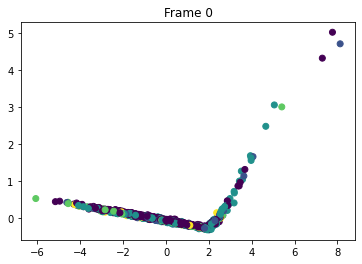

In [89]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#%matplotlib notebook

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Define an update function for the animation
def update(frame):
    ax.clear()
    ax.set_title(f'Frame {frame}')
    
    # Get the PCA result for the current frame
    pca_result = frames[frame]
    
    # Scatter plot of PCA results with color based on index
    scatter = ax.scatter(pca_result[:, 1], pca_result[:, 2], c=label)
    




# Create the animation
ani = FuncAnimation(fig, update, frames=len(frames), repeat=True)

# Display the animation as HTML
HTML(ani.to_jshtml())

In [90]:
if model.is_variational:
    if model.use_convolution:
        ani.save('../img/GDS_pca_convVAE_0.mp4', writer='ffmpeg')
    else:
        ani.save('../img/GDS_pca_VAE_0.mp4', writer='ffmpeg')

else:
    if model.use_convolution:
        ani.save('../img/GDS_pca_convAE_0.mp4', writer='ffmpeg')
    else:
        ani.save('../img/GDS_pca_AE_0.mp4', writer='ffmpeg')


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../img/GDS_pca_convAE_0.mp4
